# Data Exploration

In [6]:
%run setup.py

time: 48.9 s (started: 2021-08-07 13:38:31 +00:00)


In [7]:
train.head()

,pickup_date,total_rides,total_takings
0,2013-08-01,307272,4.567414e+06
1,2013-08-02,236761,3.534616e+06
2,2013-08-03,226554,3.182267e+06
3,2013-08-04,202310,3.073609e+06
4,2013-08-05,406487,6.657713e+06


time: 8.19 ms (started: 2021-08-07 13:39:20 +00:00)


## MLFlow Setup

In [8]:
import mlflow

time: 1.57 s (started: 2021-08-07 13:39:20 +00:00)


In [9]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 460 µs (started: 2021-08-07 13:39:21 +00:00)


The taxi_daily_forecast experiment has already been created

In [85]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
import numpy as np

time: 489 µs (started: 2021-08-08 13:57:20 +00:00)


In [110]:
cv = SlidingWindowSplitter(fh=7, window_length=56, step_length=7)

time: 329 µs (started: 2021-08-08 14:59:07 +00:00)


In [111]:
# check the split points
cv.get_cutoffs(y=train['total_rides'])

array([ 55,  62,  69,  76,  83,  90,  97, 104, 111, 118, 125, 132, 139,
       146, 153, 160, 167, 174, 181, 188, 195, 202, 209, 216, 223, 230,
       237, 244, 251, 258, 265, 272, 279, 286, 293, 300, 307, 314, 321,
       328, 335, 342, 349, 356, 363, 370, 377, 384, 391, 398, 405, 412,
       419, 426, 433, 440, 447, 454, 461, 468, 475, 482, 489, 496, 503,
       510, 517, 524, 531, 538, 545, 552, 559, 566, 573, 580, 587, 594,
       601, 608, 615, 622, 629, 636, 643, 650, 657, 664, 671, 678, 685,
       692, 699, 706, 713, 720])

time: 2.55 ms (started: 2021-08-08 14:59:08 +00:00)


In [112]:
# check the number of splits
cv.get_n_splits(y=train['total_rides'])

96

time: 2.05 ms (started: 2021-08-08 14:59:09 +00:00)


## Fitting Models

In [89]:
from sktime.forecasting.model_evaluation import evaluate

time: 288 µs (started: 2021-08-08 13:57:27 +00:00)


In [90]:
#forecaster = AutoETS(auto=True, sp=7, n_jobs=-1)
forecaster = TBATS(
     use_box_cox=False,
     use_trend=False,
     use_damped_trend=False,
     sp=7,
     use_arma_errors=False,
     n_jobs=-1)

time: 430 µs (started: 2021-08-08 13:57:30 +00:00)


In [91]:
evaluation_results = evaluate(forecaster=forecaster, y=train['total_rides'].astype('float64'), 
         cv=cv, strategy="update", return_data=True)

/home/jovyan/.local/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:693: UserWarning: NotImplementedWarning: TBATS does not have a custom `update` method implemented. TBATS will be refit each time `update` is called.
  warn(
/home/jovyan/.local/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:693: UserWarning: NotImplementedWarning: TBATS does not have a custom `update` method implemented. TBATS will be refit each time `update` is called.
  warn(
/home/jovyan/.local/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:693: UserWarning: NotImplementedWarning: TBATS does not have a custom `update` method implemented. TBATS will be refit each time `update` is called.
  warn(
/home/jovyan/.local/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:693: UserWarning: NotImplementedWarning: TBATS does not have a custom `update` method implemented. TBATS will be refit each time `update` is called.
  warn(
/home/jovyan/.local/lib/python3.8/site-packages/

time: 10min 7s (started: 2021-08-08 13:57:37 +00:00)


In [92]:
evaluation_results.columns

Index(['test_MeanAbsolutePercentageError', 'fit_time', 'pred_time',
       'len_train_window', 'cutoff', 'y_train', 'y_test', 'y_pred'],
      dtype='object')

time: 2.02 ms (started: 2021-08-08 14:07:45 +00:00)


In [93]:
evaluation_results.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.022012,5.429159,0.007289,28,27.0,0 307272.0 1 236761.0 2 226554.0 3...,"34 454753.0 Name: total_rides, dtype: float64",34 444851.936474 dtype: float64
1,0.092416,5.444932,0.008147,28,34.0,7 437214.0 8 489393.0 9 445096.0 1...,"41 502234.0 Name: total_rides, dtype: float64",41 457869.533586 dtype: float64
2,0.034709,5.718702,0.007326,28,41.0,14 473737.0 15 450037.0 16 438308.0 1...,"48 486310.0 Name: total_rides, dtype: float64",48 503487.494075 dtype: float64
3,0.048289,5.213874,0.009579,28,48.0,21 471540.0 22 464846.0 23 448911.0 2...,"55 464088.0 Name: total_rides, dtype: float64",55 487052.835529 dtype: float64
4,0.031409,5.583951,0.007154,28,55.0,28 456095.0 29 457632.0 30 435400.0 3...,"62 478552.0 Name: total_rides, dtype: float64",62 463753.429954 dtype: float64


time: 32.4 ms (started: 2021-08-08 14:07:45 +00:00)


In [94]:
evaluation_results.y_test

0      34    454753.0
Name: total_rides, dtype: float64
1      41    502234.0
Name: total_rides, dtype: float64
2      48    486310.0
Name: total_rides, dtype: float64
3      55    464088.0
Name: total_rides, dtype: float64
4      62    478552.0
Name: total_rides, dtype: float64
                            ...                        
95    699    439718.0
Name: total_rides, dtype: float64
96    706    438098.0
Name: total_rides, dtype: float64
97    713    449014.0
Name: total_rides, dtype: float64
98    720    436945.0
Name: total_rides, dtype: float64
99    727    451743.0
Name: total_rides, dtype: float64
Name: y_test, Length: 100, dtype: object

time: 16.6 ms (started: 2021-08-08 14:07:45 +00:00)


In [95]:
evaluation_results.index

RangeIndex(start=0, stop=100, step=1)

time: 4.95 ms (started: 2021-08-08 14:07:45 +00:00)


## Evaluating the results

<AxesSubplot:>

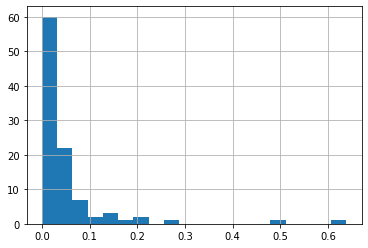

time: 109 ms (started: 2021-08-08 14:07:45 +00:00)


In [96]:
# histogram of fit loops
evaluation_results.test_MeanAbsolutePercentageError.hist(bins=20)

# Testing Multiple Forecasters

In [102]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.model_selection import ForecastingGridSearchCV

time: 393 µs (started: 2021-08-08 14:45:12 +00:00)


In [103]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=7)),
        ("tbats", TBATS(use_box_cox=False, use_trend=False,
                     use_damped_trend=False, sp=7,
                     use_arma_errors=False, n_jobs=-1))
    ],
)

time: 393 µs (started: 2021-08-08 14:45:12 +00:00)


In [104]:
forecaster_param_grid = {"selected_forecaster": ["ets", "naive", "tbats"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

time: 372 µs (started: 2021-08-08 14:47:04 +00:00)


In [113]:
gscv.fit(train['total_rides'].astype('float64'))

/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarn

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=7, step_length=7, window_length=28),
                        forecaster=MultiplexForecaster(forecasters=[('naive',
                                                                     NaiveForecaster()),
                                                                    ('ets',
                                                                     ExponentialSmoothing(sp=7,
                                                                                          trend='add')),
                                                                    ('tbats',
                                                                     TBATS(n_jobs=-1,
                                                                           sp=7,
                                                                           use_arma_errors=False,
                                                                           use_box_cox=False,
                              

time: 8min 48s (started: 2021-08-08 14:59:18 +00:00)


In [114]:
gscv.best_params_

{'selected_forecaster': 'naive'}

time: 1.28 ms (started: 2021-08-08 15:08:06 +00:00)


## Testing TSFresh

In [115]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

time: 1.94 s (started: 2021-08-09 13:40:58 +00:00)


In [124]:
train[['total_rides']].pivot(values)

(730,)

time: 1.6 ms (started: 2021-08-09 13:45:23 +00:00)


In [ ]:
reformat_frame = pd.DataFrame()

In [123]:
t = TSFreshFeatureExtractor(show_warnings=False)
Xt = t.fit_transform(train['total_rides']) # train[['total_rides','total_takings']]
Xt.head()

ValueError: If passed as a np.array, X must be a 3-dimensional array, but found shape: (730,)

time: 9.84 ms (started: 2021-08-09 13:45:10 +00:00)


In [120]:
### Testing
from sktime.datasets import load_airline
y = load_airline()
type(y.head())

pandas.core.series.Series

time: 6.07 ms (started: 2021-08-09 13:44:13 +00:00)
